In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient
from pprint import pprint

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']

num_votazioni = 250
num_film = 5

## Seleziono solo i film che hanno ricevuto almeno un tot numero di votazioni

In [2]:
metadata_coll = db.metadata

movie_rates_df = pd.DataFrame(metadata_coll.find({},{'_id':'_id', 'vote_average':'vote_average','vote_count':'vote_count'}))
movie_rates_df = movie_rates_df.rename(columns={'_id':'movie_id'})
movie_rates_df = movie_rates_df.loc[movie_rates_df['vote_count'] >= num_votazioni]
movie_rates_df


,movie_id,vote_average,vote_count
0,862,7.7,5415.0
1,8844,6.9,2413.0
5,949,7.7,1886.0
9,710,6.6,1194.0
12,21032,7.1,423.0
...,...,...,...
44924,269795,5.5,277.0
44982,353491,5.7,688.0
45107,378236,5.8,327.0
45142,339692,6.9,324.0


In [3]:

#people_coll = db.people
#actors_df = pd.DataFrame(people_coll.find( {'jobs': { '$in': ["Actor"]} },{'_id':'_id', 'name':'name'}))
#actors_df


## Filtro gli attori in base ad un dato numero di film  

In [4]:


cast_coll = db.cast
cast_df = pd.DataFrame(cast_coll.find({},{'movie_id':'movie_id', 'person_id':'person_id'})).drop(columns='_id')
#cast_df.head()

actors_num_film_df = cast_df.groupby('person_id').count().reset_index().rename(columns={'movie_id':'num_film'})
actors_num_film_df = actors_num_film_df.loc[actors_num_film_df['num_film'] >= num_film]

actors_movie_num_film_df = pd.merge(cast_df,actors_num_film_df, on='person_id')
actors_movie_num_film_df


,person_id,movie_id,num_film
0,31.0,862.0,72
1,31.0,568.0,72
2,31.0,13.0,72
3,31.0,9800.0,72
4,31.0,858.0,72
...,...,...,...
306008,559985.0,62688.0,5
306009,559985.0,20884.0,5
306010,559985.0,148347.0,5
306011,559985.0,313556.0,5


## Film e attori che vi hanno partecipato

In [5]:
movies_actor_df = pd.merge(actors_movie_num_film_df,movie_rates_df, on='movie_id').drop(columns=['vote_count','num_film'])

movies_actor_df.groupby(['movie_id','person_id']).first()



vote_average
movie_id person_id              
5.0      62.0                6.5
         138.0               6.5
         2555.0              6.5
         3122.0              6.5
         3124.0              6.5
...                          ...
419430.0 1069644.0           7.2
         1200864.0           7.2
         1242199.0           7.2
         1291961.0           7.2
         1299674.0           7.2

[51601 rows x 1 columns]

## Attori e punteggio bravura
### punteggio bravura = media voti dei film a cui hanno partecipato 

In [6]:
 
actors_mean_rate_films = movies_actor_df.groupby('person_id').mean().reset_index().drop(columns='movie_id').rename(columns=   {'vote_average':'vote_average_films'})

actors_mean_rate_films.head()

,person_id,vote_average_films
0,1.0,6.600000
1,2.0,7.414286
2,3.0,6.716129
3,4.0,6.864286
4,5.0,8.100000


## Calcolo della valutazione media di bravura del cast per ogni film 

In [7]:
tmp = pd.merge(movies_actor_df, actors_mean_rate_films, on='person_id')
movies_cast_vote_average_df = tmp.groupby('movie_id').mean().reset_index().rename(columns={'vote_average_films':'cast_vote_average'}).drop(columns='person_id')

movies_cast_vote_average_df.head(100)


,movie_id,vote_average,cast_vote_average
0,5.0,6.5,6.498812
1,11.0,8.1,7.495747
2,12.0,7.6,6.795296
3,13.0,8.2,7.081989
4,14.0,7.9,6.927583
...,...,...,...
95,177.0,7.2,6.805055
96,179.0,6.2,6.483287
97,180.0,7.1,6.655930
98,184.0,7.3,6.648406


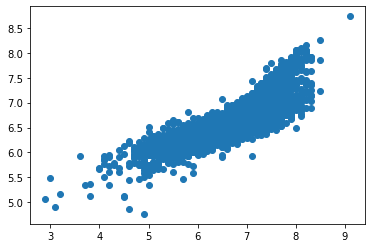

In [8]:
import matplotlib.pyplot as plt 
plt.scatter(movies_cast_vote_average_df.vote_average,movies_cast_vote_average_df.cast_vote_average)


# Sotto ipotesi 1: cambio metodo punteggio bravura attore
###    Dato un film seleziono solo i film a cui ha partecipato l'attore fino a quel momento

In [9]:

movie_rates_date_df = pd.DataFrame(metadata_coll.find({},{'_id':'_id', 'vote_average':'vote_average','vote_count':'vote_count','release_date':'release_date'}))
movie_rates_date_df = movie_rates_date_df.rename(columns={'_id':'movie_id'})
movie_rates_date_df = movie_rates_date_df.loc[movie_rates_date_df['vote_count'] >= num_votazioni]

movie_rates_date_df['release_date'] = pd.to_datetime(movie_rates_date_df['release_date'],
                                                     format="%Y/%m/%d")
movie_rates_date_df.head()

,movie_id,release_date,vote_average,vote_count
0,862,1995-10-30,7.7,5415.0
1,8844,1995-12-15,6.9,2413.0
5,949,1995-12-15,7.7,1886.0
9,710,1995-11-16,6.6,1194.0
12,21032,1995-12-22,7.1,423.0


### Creo un dizionario in cui come chiave ho una tupla che contiene l'id del film, la sua data di uscita e la sua valutazione

In [14]:

movies_actor_date_df = pd.merge(actors_movie_num_film_df,movie_rates_date_df, on='movie_id').drop(columns=['num_film','vote_count'])
movie_id_date_actors_dict = movies_actor_date_df.groupby(['movie_id','release_date','vote_average'])['person_id'].apply(list).to_dict()
movies_actor_date_df.head()

,person_id,movie_id,release_date,vote_average
0,31.0,862.0,1995-10-30,7.7
1,12898.0,862.0,1995-10-30,7.7
2,7167.0,862.0,1995-10-30,7.7
3,12899.0,862.0,1995-10-30,7.7
4,12900.0,862.0,1995-10-30,7.7


### Dato un film e il suo cast, per ogni attore del cast calcolo la valutazione media dei film a cui ha precedentemente partecipato. 
### Se risulta essere il primo film girato dall'attore  la media sarà nulla.

In [11]:
import math

index = 0
formatted_dict_for_df = {}

for movie_id, date, rating  in movie_id_date_actors_dict:
    person_id_average_rate_before_actual_list = []
    for person_id in movie_id_date_actors_dict[(movie_id, date,rating)]:
        films_before_actual_df = movies_actor_date_df.loc[(movies_actor_date_df['person_id'] == person_id) & (movies_actor_date_df['release_date'] <  date) & (movies_actor_date_df['movie_id'] != movie_id)]
        mean_rating_film_before_actual = films_before_actual_df['vote_average'].mean()
        if math.isnan(mean_rating_film_before_actual):
            mean_rating_film_before_actual = 0
        person_id_average_rate_before_actual_list.append(mean_rating_film_before_actual)

    key_values = [movie_id,rating, pd.Series(person_id_average_rate_before_actual_list).mean() ]
    formatted_dict_for_df[index] = key_values
    index += 1


### Il dataframe seguente mostra il film con la sua valutazione e un terzo parametro che rappresenta la media dei punteggi bravura di ogni membro del cast.
#### Punteggio bravura per attore = media delle valutazioni dei film in cui l'attore ha precedentemente partecipato 

In [12]:
movies_rating_before_actual_df = pd.DataFrame.from_dict(formatted_dict_for_df, orient='index',  columns=['movie_id', 'vote_average', 'cast_rate_average_previous'])
movies_rating_before_actual_df

,movie_id,vote_average,cast_rate_average_previous
0,5.0,6.5,6.254784
1,11.0,8.1,2.443627
2,12.0,7.6,5.659583
3,13.0,8.2,3.466917
4,14.0,7.9,3.874561
...,...,...,...
3408,417644.0,6.2,5.900796
3409,417678.0,7.3,4.646667
3410,417870.0,7.1,6.400762
3411,418078.0,5.6,6.583750


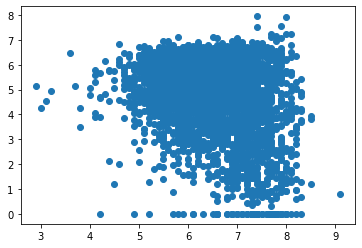

In [13]:
plt.scatter(movies_rating_before_actual_df.vote_average,movies_rating_before_actual_df.cast_rate_average_previous)
